<a href="https://colab.research.google.com/github/dtuleva/DL_23_Lectures_and_Quests/blob/main/DL04_NN_for_Language_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
import tensorflow as tf

from tensorflow.keras.datasets import imdb

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAvgPool1D, LSTM, LSTMCell, Bidirectional, Embedding
# RNN is the base class, both LSTM and LSTMcell work, they are NOT the same thing, GRU and GRUCell
# Dropout does not behave properly in recurrent layers, recurrent dropout is not very good idea also, temporal dropout can help

# 04.Neural-Networks-for-Language-Processing
### from video

Resume helper - [open review](https://openreview.net/group?id=NeurIPS.cc)

State why NN is needed for the task

Knowlage destilation - take huge model and downsize it

## Time Sequences

времеви ред с 1 измерение - conv1D

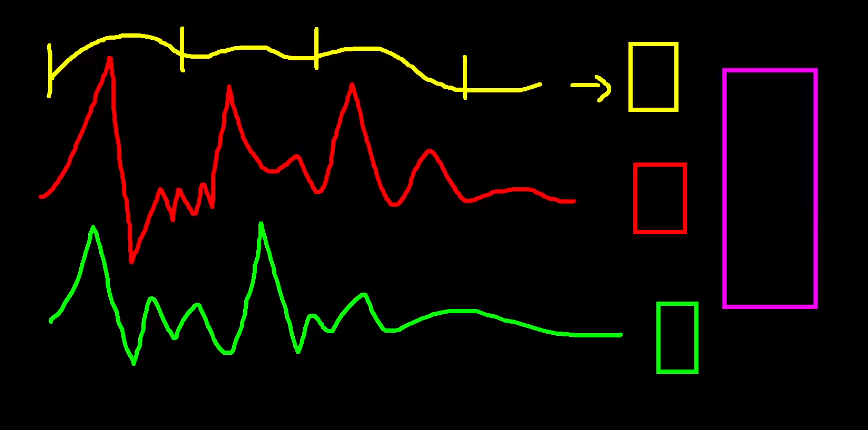

Each time series can be interpreted as a channel and TADAA a model that understands time.

If the sampling rate is differenet - separate conv filters in the first layer and concat / add results; or oversampling, undersampling or combination of both; or take not the time series itself, but the differences (as pansad .diff) so we end up with column time difference and column feature difference (very common approach in astrophysics)

Same advantages as 2Dconv, very good for numerical time sieries - not that good for text. Reason is that a lot of information gets lost by convolutions of the model is very deep, for this case attention or residuals work better.

A model with huge capacity can never be stable - more params = easier to overfit.

deep nn on tfidf matrix is very good for classification / non generative tasks

audio can be treated as it's spectrogram - great for classification tasks, fingerprinting (Shazam works this way), or recommendation

## Tokenisation

For English - usually use 14 - 15 000 words in volcabulary - ```<UKN>``` token

other special tokens ```<|startoftext|>```, ```<|endoftext|>```

Token can be symbol, n-gram, edge-gram ... Word token can be ok for english (no too many prefixes, suffixes and conjugations), model does not need to learn to build words; very very bad for languages with agglutination (concat words like German and Hungarian)

In most new models 1 tocken is byte pair - no unknown token; many tokens in volcabulary; need for more training - to learn build words from byte pairs

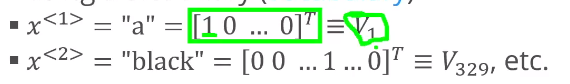

$V_1$ vector with index 1 means the 1 in one-hot encoding is in 1st position

ohe means that every token is independent

$x^{<2>}$ position in text

$a^{(2)}$ layer

$a^{[2]}$ element in layer



## Type of models

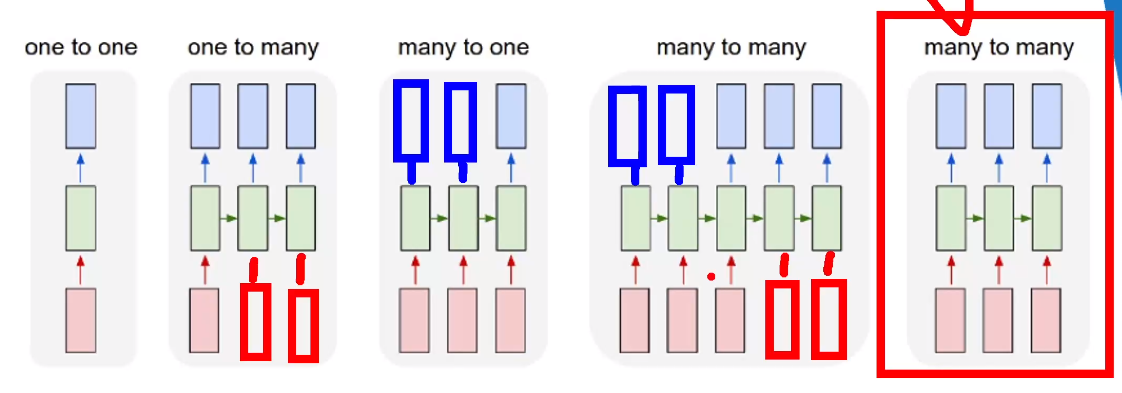

__one-to-one__ means no time-dependent model

_everything_ else is __many-to-many__, just some inputs are 0 or we don't care about the outputs ( but they are needed for GD)

examples:

__one-to-many__ - generative / completion model - prompt (can be one word) generate sentence

__many-to-one__ - classification of text - sentiment analysis; sentiment as a spectre from -1 to +1

__many-to-many__ (left) - generative - needs the whole sentence to translate it

__many-to-many__ (right) - video - seqience of frames, for each frame predict where is the main character


## Language model

Foundational model that predicts next token with probability - super simple task, unsupervised (no need for annotations), can be used as backbone for whatever task.

Just like image backbones are built on image classification task.

### RNN

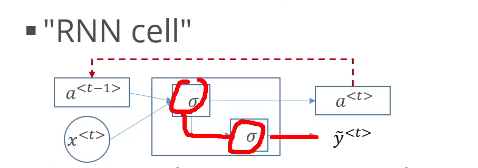

### GRU gated reccurent unit

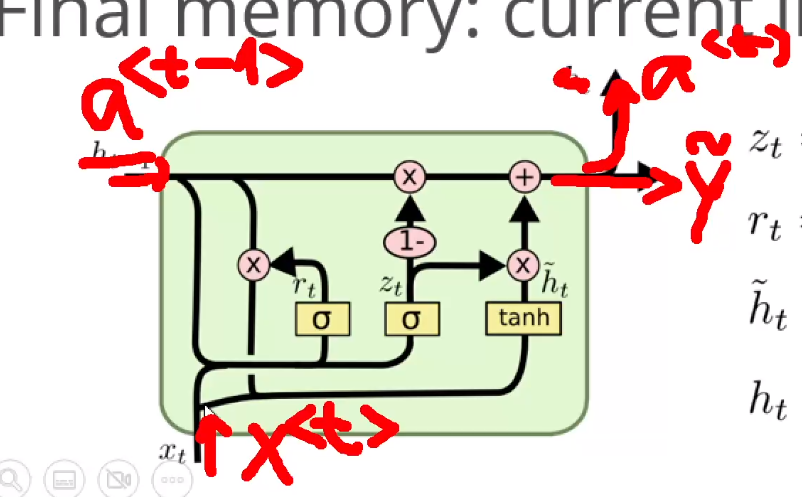

again, context, input and context, prediction pairs, but here context out and prediction hava the same output

$h_t$ (or a-context) is weighted sum

## Demo

In [90]:
VOCABULARY_SIZE = 10_000
OOV = 0 # needs to be inside 0, depth for ohe/embedding
SEQUENCE_LENGTH = 800
EMBEDDING_LENGTH = 256


In [91]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = VOCABULARY_SIZE, oov_char = OOV)

In [92]:
(x_train.shape, y_train.shape), (x_test.shape, y_test.shape)

(((25000,), (25000,)), ((25000,), (25000,)))

In [93]:
len(x_train[0]), len(x_train[10]) # elements with variable length

(218, 450)

In [96]:
x_train_padded = tf.keras.utils.pad_sequences(x_train, maxlen = SEQUENCE_LENGTH, padding = "post")
x_train_padded

array([[   1,   14,   22, ...,    0,    0,    0],
       [   1,  194, 1153, ...,    0,    0,    0],
       [   1,   14,   47, ...,    0,    0,    0],
       ...,
       [   1,   11,    6, ...,    0,    0,    0],
       [   1, 1446, 7079, ...,    0,    0,    0],
       [   1,   17,    6, ...,    0,    0,    0]], dtype=int32)

In [97]:
imdb.get_word_index()["the"]

1

In [98]:
indeces = imdb.get_word_index()

In [99]:
words = {v: k for k, v in indeces.items()}

In [100]:
indeces["movie"]

17

In [101]:
words[22]

'you'

all RNNs are sequential -> hard to parallelize -> perform poorly on GPU -> restrictions from keras for optimal performance specific activations, bias, dropout etc. -> for LSTM:

The requirements to use the cuDNN implementation are:

+ activation == tanh
+ recurrent_activation == sigmoid
+ recurrent_dropout == 0
+ unroll is False
+ use_bias is True
+ Inputs, if use masking, are strictly right-padded.
+ Eager execution is enabled in the outermost context.

Else computed on CPU

In [102]:
tf.keras.backend.clear_session()

In [103]:
model = Sequential([
    Input((SEQUENCE_LENGTH, 32)), # batch size x sequence len x 32
    # input does not need to be whole text, can be taken as sliding window with or without repetition only with tf.dataset.skip() and take()
    LSTM(5, return_sequences = True), # has htan activation by default, not None
    LSTM(10, return_sequences = True),
    LSTM(5, return_sequences = False), # either do not return seq in last lstm
    # or add Flatten or GlobalPooling 1D layer before the classification head
    Dense(VOCABULARY_SIZE, activation = "sigmoid") # dense layer changes only the last dim, keeps all other the same
])


In [104]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 800, 5)            760       
                                                                 
 lstm_1 (LSTM)               (None, 800, 10)           640       
                                                                 
 lstm_2 (LSTM)               (None, 5)                 320       
                                                                 
 dense (Dense)               (None, 10000)             60000     
                                                                 
Total params: 61720 (241.09 KB)
Trainable params: 61720 (241.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [105]:
result = model.predict(tf.random.uniform((8, SEQUENCE_LENGTH, 32))) # 8 as batch size

1/1 [==============================] - 1s 1s/step


In [106]:
result.shape

(8, 10000)

In [107]:
# result[:, -1, :] # last result from the many-tomany model (with return_sequences = True)

In [108]:
bidirectional_model = Sequential([
    Input((SEQUENCE_LENGTH, 32)),
    Bidirectional(LSTM(5, return_sequences = True))

])

when usingf bidirectional, make sure we are allowed to have the whole sequence at once - translate a whole sentence (word order start to end and end to start); cannot be applied to real time series (predictions with future data is fallacy)

In [109]:
bidirectional_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 800, 10)           1520      
 al)                                                             
                                                                 
Total params: 1520 (5.94 KB)
Trainable params: 1520 (5.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [110]:
pca = Sequential([
    Input(10000),
    Dense(32, use_bias = False)
])

In [111]:
tf.one_hot([15], depth=10000)

<tf.Tensor: shape=(1, 10000), dtype=float32, numpy=array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [135]:
# shortcut for ohe and single dense layer without bias = embedding, absolutely equivalent
model = Sequential([
    # Input((SEQUENCE_LENGTH, 32))

    Embedding(input_dim = VOCABULARY_SIZE, output_dim = EMBEDDING_LENGTH, input_length = SEQUENCE_LENGTH),

    LSTM(5, return_sequences = True),
    LSTM(10, return_sequences = True),
    LSTM(5, return_sequences = True),
    Dense(VOCABULARY_SIZE, activation = "softmax")
])

In [136]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 800, 256)          2560000   
                                                                 
 lstm_10 (LSTM)              (None, 800, 5)            5240      
                                                                 
 lstm_11 (LSTM)              (None, 800, 10)           640       
                                                                 
 lstm_12 (LSTM)              (None, 800, 5)            320       
                                                                 
 dense_4 (Dense)             (None, 800, 10000)        60000     
                                                                 
Total params: 2626200 (10.02 MB)
Trainable params: 2626200 (10.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [137]:
predictions = model.predict(x_train_padded[:5])

1/1 [==============================] - 2s 2s/step


In [138]:
predictions.shape

(5, 800, 10000)

In [139]:
tf.argmax(predictions, axis = 1)

<tf.Tensor: shape=(5, 10000), dtype=int64, numpy=
array([[294,  50,  77, ..., 128,  77,  78],
       [265,  28,  85, ..., 169, 177, 177],
       [213,  18, 107, ..., 108,  69,  17],
       [625, 418, 547, ..., 221, 356, 355],
       [216,  99,  32, ..., 114,  89, 130]])>

In [140]:
model.compile(loss = "sparse_categorical_crossentropy") # or categorical with sigmoid

sigmoid = undependent
softmax = dependent; sum proba to 1

In [141]:
x_train_padded[:5]

array([[   1,   14,   22, ...,    0,    0,    0],
       [   1,  194, 1153, ...,    0,    0,    0],
       [   1,   14,   47, ...,    0,    0,    0],
       [   1,    4,    0, ...,    0,    0,    0],
       [   1,  249, 1323, ...,    0,    0,    0]], dtype=int32)

In [142]:
model.layers[0](x_train_padded[1:6]).shape

TensorShape([5, 800, 256])

In [146]:
# x_train_padded[1:].tolist() + [0]

In [147]:
# model.fit(The cat sits in the, box) # with dataset skip and take